In [1]:
#!pip install transformers requests beautifulsoup4 pandas numpy

In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
#!pip install matplotlib wordcloud

In [4]:
# importing the required libraries
import pandas as pd
import re
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from scipy.special import softmax

In [5]:
# Loading  the Excel file
df = pd.read_excel('sentiment_analysis_output.xlsx')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5486 entries, 0 to 5485
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   User           5486 non-null   object        
 1   Username       5486 non-null   object        
 2   UTC Date       5486 non-null   datetime64[ns]
 3   Tweet          5486 non-null   object        
 4   Binders        0 non-null      float64       
 5   Permalink      5486 non-null   object        
 6   Retweets       5486 non-null   int64         
 7   Likes count    5486 non-null   int64         
 8   Impressions    5486 non-null   int64         
 9   Quotes         5486 non-null   int64         
 10  Replies        5486 non-null   int64         
 11  Bookmarks      5486 non-null   int64         
 12  Tweet value    5486 non-null   float64       
 13  Cleaned_Tweet  5478 non-null   object        
 14  Negative       5486 non-null   float64       
 15  Neutral        5486 n

In [7]:
# Removing irrelevant columns
irrelevant_columns = ['Binders', 'Permalink', 'Impressions', 'Quotes', 'Replies', 'Bookmarks', 'Tweet value', 'Username', 'Retweets', 'Likes count']
df = df.drop(irrelevant_columns, axis=1)

In [8]:
# Loading the Roberta model for emotion analysis
MODEL = 'cardiffnlp/twitter-roberta-base-emotion'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def emotion_scores_roberta(example):
    encoded_text = tokenizer([example], return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores

In [9]:
def emotion_scores_roberta(example):
    if not isinstance(example, str):
        example = str(example)

    encoded_text = tokenizer([example], return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores

In [10]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Cleaned_Tweet'] 
        myid = i  
        roberta_result = emotion_scores_roberta(text)
        res[myid] = roberta_result.tolist()
    except RuntimeError:
        print(f'Broke for id {myid}')


100%|██████████████████████████████████████████████████████████████████████████████| 5486/5486 [04:58<00:00, 18.38it/s]


In [11]:
res

{0: [0.0413871631026268,
  0.8363601565361023,
  0.09463988244533539,
  0.02761286497116089],
 1: [0.2730911672115326,
  0.22054125368595123,
  0.17942415177822113,
  0.32694345712661743],
 2: [0.038950979709625244,
  0.08443807065486908,
  0.8489846587181091,
  0.027626248076558113],
 3: [0.0758882462978363,
  0.3434101343154907,
  0.447382390499115,
  0.1333191990852356],
 4: [0.20080025494098663,
  0.5239750742912292,
  0.1408977061510086,
  0.13432693481445312],
 5: [0.011366251856088638,
  0.932201087474823,
  0.0440618135035038,
  0.012370821088552475],
 6: [0.1293400526046753,
  0.5739045143127441,
  0.16361373662948608,
  0.1331416517496109],
 7: [0.015401170589029789,
  0.9539887309074402,
  0.02058735117316246,
  0.010022778995335102],
 8: [0.023693690076470375,
  0.9210578203201294,
  0.041423000395298004,
  0.013825488276779652],
 9: [0.18860451877117157,
  0.35268738865852356,
  0.2633120119571686,
  0.19539611041545868],
 10: [0.04829834774136543,
  0.2816007137298584,
  

In [12]:
# Converting the results to a DataFrame
results_df = pd.DataFrame(res).T
results_df.columns = ['Joy', 'Neutral', 'Anger', 'Sadness']  

# Adding the emotion scores to the existing DataFrame
df[['Joy', 'Neutral', 'Anger', 'Sadness']] = results_df[['Joy', 'Neutral', 'Anger', 'Sadness']]

# Map emotion labels 
df['Emotion'] = df[['Joy', 'Neutral', 'Anger', 'Sadness']].idxmax(axis=1)
df['Emotion'] = df['Emotion'].map({'Joy': 'joy', 'Neutral': 'neutral', 'Anger': 'anger', 'Sadness': 'sadness'})

print("Results DataFrame:")
print(df[['Cleaned_Tweet', 'Emotion']])

Results DataFrame:
                                          Cleaned_Tweet  Emotion
0     really informative talk ex member hm force pro...  neutral
1                        procurement assistant hull see  sadness
2     better together event hosted community coming ...    anger
3     last night might seen one rookie red look nort...    anger
4                                    get launch profile  neutral
...                                                 ...      ...
5481  control hfrs deploying two high volume pump as...  sadness
5482  work homeless hostel resident heard gentleman ...  sadness
5483  ill talking three significant rescue performed...  sadness
5484                       confirmed far like one going  neutral
5485  another night saving life might job stop think...  sadness

[5486 rows x 2 columns]


In [13]:
df

,User,UTC Date,Tweet,Cleaned_Tweet,Negative,Neutral,Positive,Sentiment,Year,Joy,Anger,Sadness,Emotion
0,Community Safety,2023-11-08 22:16:00,Really informative talk from an Ex Member HM F...,really informative talk ex member hm force pro...,0.003928,0.836360,0.865853,positive,2023,0.041387,0.094640,0.027613,neutral
1,JCPinHumber/NthYorks,2023-11-08 14:01:00,Procurement Assistant @HumbersideFire in Hull\...,procurement assistant hull see,0.201464,0.220541,0.068592,neutral,2023,0.273091,0.179424,0.326943,sadness
2,Community Safety,2023-11-08 13:35:18,Better Together Event hosted by @Humberbeat co...,better together event hosted community coming ...,0.002524,0.084438,0.846982,positive,2023,0.038951,0.848985,0.027626,anger
3,Humberside Fire & Rescue,2023-11-08 12:23:49,Last night you might have seen one of our Rook...,last night might seen one rookie red look nort...,0.003719,0.343410,0.238884,neutral,2023,0.075888,0.447382,0.133319,anger
4,Kristian Gilmore,2023-11-07 23:01:06,@HallMohame77536 @Sinan05073661 @elquimeras @R...,get launch profile,0.090509,0.523975,0.112513,neutral,2023,0.200800,0.140898,0.134327,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,Humberside Fire & Rescue,2019-11-10 03:11:20,Control - HFRS deploying two High Volume Pumps...,control hfrs deploying two high volume pump as...,0.164026,0.042279,0.035744,neutral,2019,0.431627,0.071510,0.454585,sadness
5482,Lesley Tidder,2019-11-09 21:46:38,"@HumbersideFire I work at a homeless hostel, r...",work homeless hostel resident heard gentleman ...,0.034116,0.127607,0.585534,positive,2019,0.051497,0.221461,0.599435,sadness
5483,Chris Blacksell DL,2019-11-09 08:59:37,I’ll be on @RadioHumberside talking about the ...,ill talking three significant rescue performed...,0.006148,0.196341,0.357048,neutral,2019,0.167967,0.189362,0.446330,sadness
5484,UK USA FIRE & POLICE,2019-11-09 08:48:44,1 confirmed #fatality so far from #England #fl...,confirmed far like one going,0.053573,0.378297,0.266302,neutral,2019,0.111971,0.375643,0.134089,neutral


In [14]:
df['Emotion'].value_counts()

Emotion
neutral    2977
sadness    1142
anger       794
joy         573
Name: count, dtype: int64

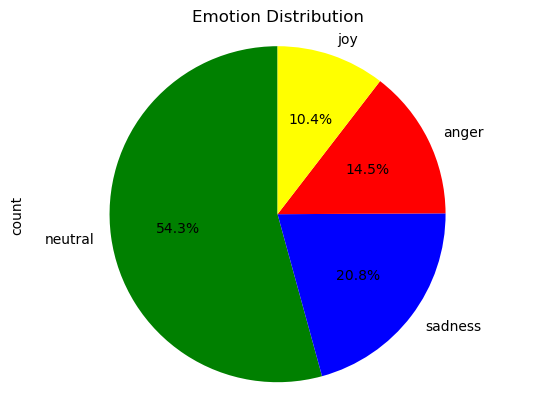

In [15]:
sentiment_counts = df['Emotion'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red','yellow'])
plt.title('Emotion Distribution')
plt.axis('equal')  
plt.show()

In [16]:
# List of user accounts to exclude
exclude_users = ['Humberside Fire & Rescue', 'Chris Blacksell DL', 'Community Safety']

In [17]:
# Filtering out rows with specified user accounts
filtered_df = df[~df['User'].isin(exclude_users)]

In [18]:
filtered_df

,User,UTC Date,Tweet,Cleaned_Tweet,Negative,Neutral,Positive,Sentiment,Year,Joy,Anger,Sadness,Emotion
1,JCPinHumber/NthYorks,2023-11-08 14:01:00,Procurement Assistant @HumbersideFire in Hull\...,procurement assistant hull see,0.201464,0.220541,0.068592,neutral,2023,0.273091,0.179424,0.326943,sadness
4,Kristian Gilmore,2023-11-07 23:01:06,@HallMohame77536 @Sinan05073661 @elquimeras @R...,get launch profile,0.090509,0.523975,0.112513,neutral,2023,0.200800,0.140898,0.134327,neutral
5,Beth,2023-11-07 20:18:02,"What an achievement for Our Rookie Mary, she h...",achievement rookie mary done amazingly persona...,0.001917,0.932201,0.960376,positive,2023,0.011366,0.044062,0.012371,neutral
7,Delta Strand,2023-11-06 23:52:56,We are so excited that our firework night is f...,excited firework night finally,0.001157,0.953989,0.982210,positive,2023,0.015401,0.020587,0.010023,neutral
8,Vicky Shakesby MBE,2023-11-06 20:05:44,Presented CM Walker his 30 year long service c...,presented cm walker year long service clasp ev...,0.004754,0.921058,0.755336,positive,2023,0.023694,0.041423,0.013825,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476,Tony Clark QFSM,2019-11-10 13:44:52,Fantastic turnout #RemembranceSunday at Howden...,fantastic turnout howden,0.021842,0.959856,0.746126,positive,2019,0.014998,0.016665,0.008482,neutral
5478,HFR Solutions CIC,2019-11-10 09:45:06,"On Remembrance Sunday, we are extremely proud ...",remembrance sunday extremely proud sponsored w...,0.001497,0.942719,0.973752,positive,2019,0.011348,0.033565,0.012368,neutral
5479,Lyndsay Howden,2019-11-10 09:01:56,Proud to represent @HumbersideFire at the Clee...,proud represent cleethorpes rememberance event...,0.003184,0.891556,0.937308,positive,2019,0.021011,0.066265,0.021168,neutral
5482,Lesley Tidder,2019-11-09 21:46:38,"@HumbersideFire I work at a homeless hostel, r...",work homeless hostel resident heard gentleman ...,0.034116,0.127607,0.585534,positive,2019,0.051497,0.221461,0.599435,sadness


In [19]:
filtered_df['Emotion'].value_counts()

Emotion
neutral    1902
sadness     654
anger       391
joy         342
Name: count, dtype: int64

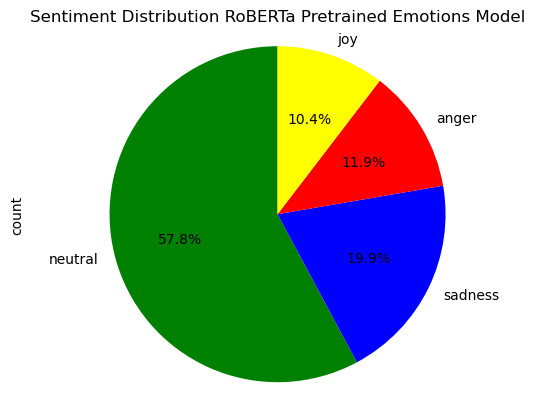

In [36]:
sentiment_counts = filtered_df['Emotion'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red','yellow'])
plt.title('Sentiment Distribution RoBERTa Pretrained Emotions Model')
plt.axis('equal')  

plt.savefig('Emotion Distribution For Emotions Classification')
plt.show()

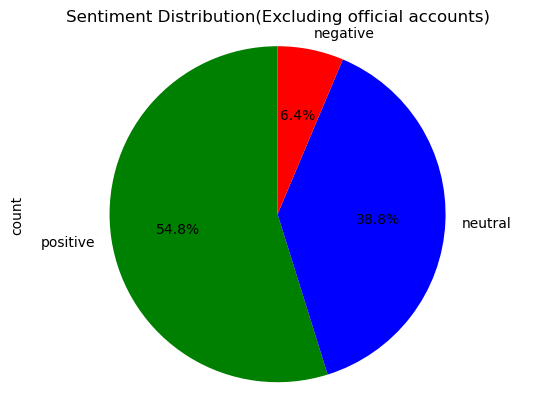

In [21]:
sentiment_counts = filtered_df['Sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red'])
plt.title('Sentiment Distribution(Excluding official accounts)')
plt.axis('equal')  
plt.show()

In [22]:
filtered_df

,User,UTC Date,Tweet,Cleaned_Tweet,Negative,Neutral,Positive,Sentiment,Year,Joy,Anger,Sadness,Emotion
1,JCPinHumber/NthYorks,2023-11-08 14:01:00,Procurement Assistant @HumbersideFire in Hull\...,procurement assistant hull see,0.201464,0.220541,0.068592,neutral,2023,0.273091,0.179424,0.326943,sadness
4,Kristian Gilmore,2023-11-07 23:01:06,@HallMohame77536 @Sinan05073661 @elquimeras @R...,get launch profile,0.090509,0.523975,0.112513,neutral,2023,0.200800,0.140898,0.134327,neutral
5,Beth,2023-11-07 20:18:02,"What an achievement for Our Rookie Mary, she h...",achievement rookie mary done amazingly persona...,0.001917,0.932201,0.960376,positive,2023,0.011366,0.044062,0.012371,neutral
7,Delta Strand,2023-11-06 23:52:56,We are so excited that our firework night is f...,excited firework night finally,0.001157,0.953989,0.982210,positive,2023,0.015401,0.020587,0.010023,neutral
8,Vicky Shakesby MBE,2023-11-06 20:05:44,Presented CM Walker his 30 year long service c...,presented cm walker year long service clasp ev...,0.004754,0.921058,0.755336,positive,2023,0.023694,0.041423,0.013825,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476,Tony Clark QFSM,2019-11-10 13:44:52,Fantastic turnout #RemembranceSunday at Howden...,fantastic turnout howden,0.021842,0.959856,0.746126,positive,2019,0.014998,0.016665,0.008482,neutral
5478,HFR Solutions CIC,2019-11-10 09:45:06,"On Remembrance Sunday, we are extremely proud ...",remembrance sunday extremely proud sponsored w...,0.001497,0.942719,0.973752,positive,2019,0.011348,0.033565,0.012368,neutral
5479,Lyndsay Howden,2019-11-10 09:01:56,Proud to represent @HumbersideFire at the Clee...,proud represent cleethorpes rememberance event...,0.003184,0.891556,0.937308,positive,2019,0.021011,0.066265,0.021168,neutral
5482,Lesley Tidder,2019-11-09 21:46:38,"@HumbersideFire I work at a homeless hostel, r...",work homeless hostel resident heard gentleman ...,0.034116,0.127607,0.585534,positive,2019,0.051497,0.221461,0.599435,sadness


In [23]:
# Converting UTC Date to datetime format and extract year, month, and week
filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])

C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\1486289520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])


C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\210610448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['UTC Date'].dt.year
C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\210610448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()


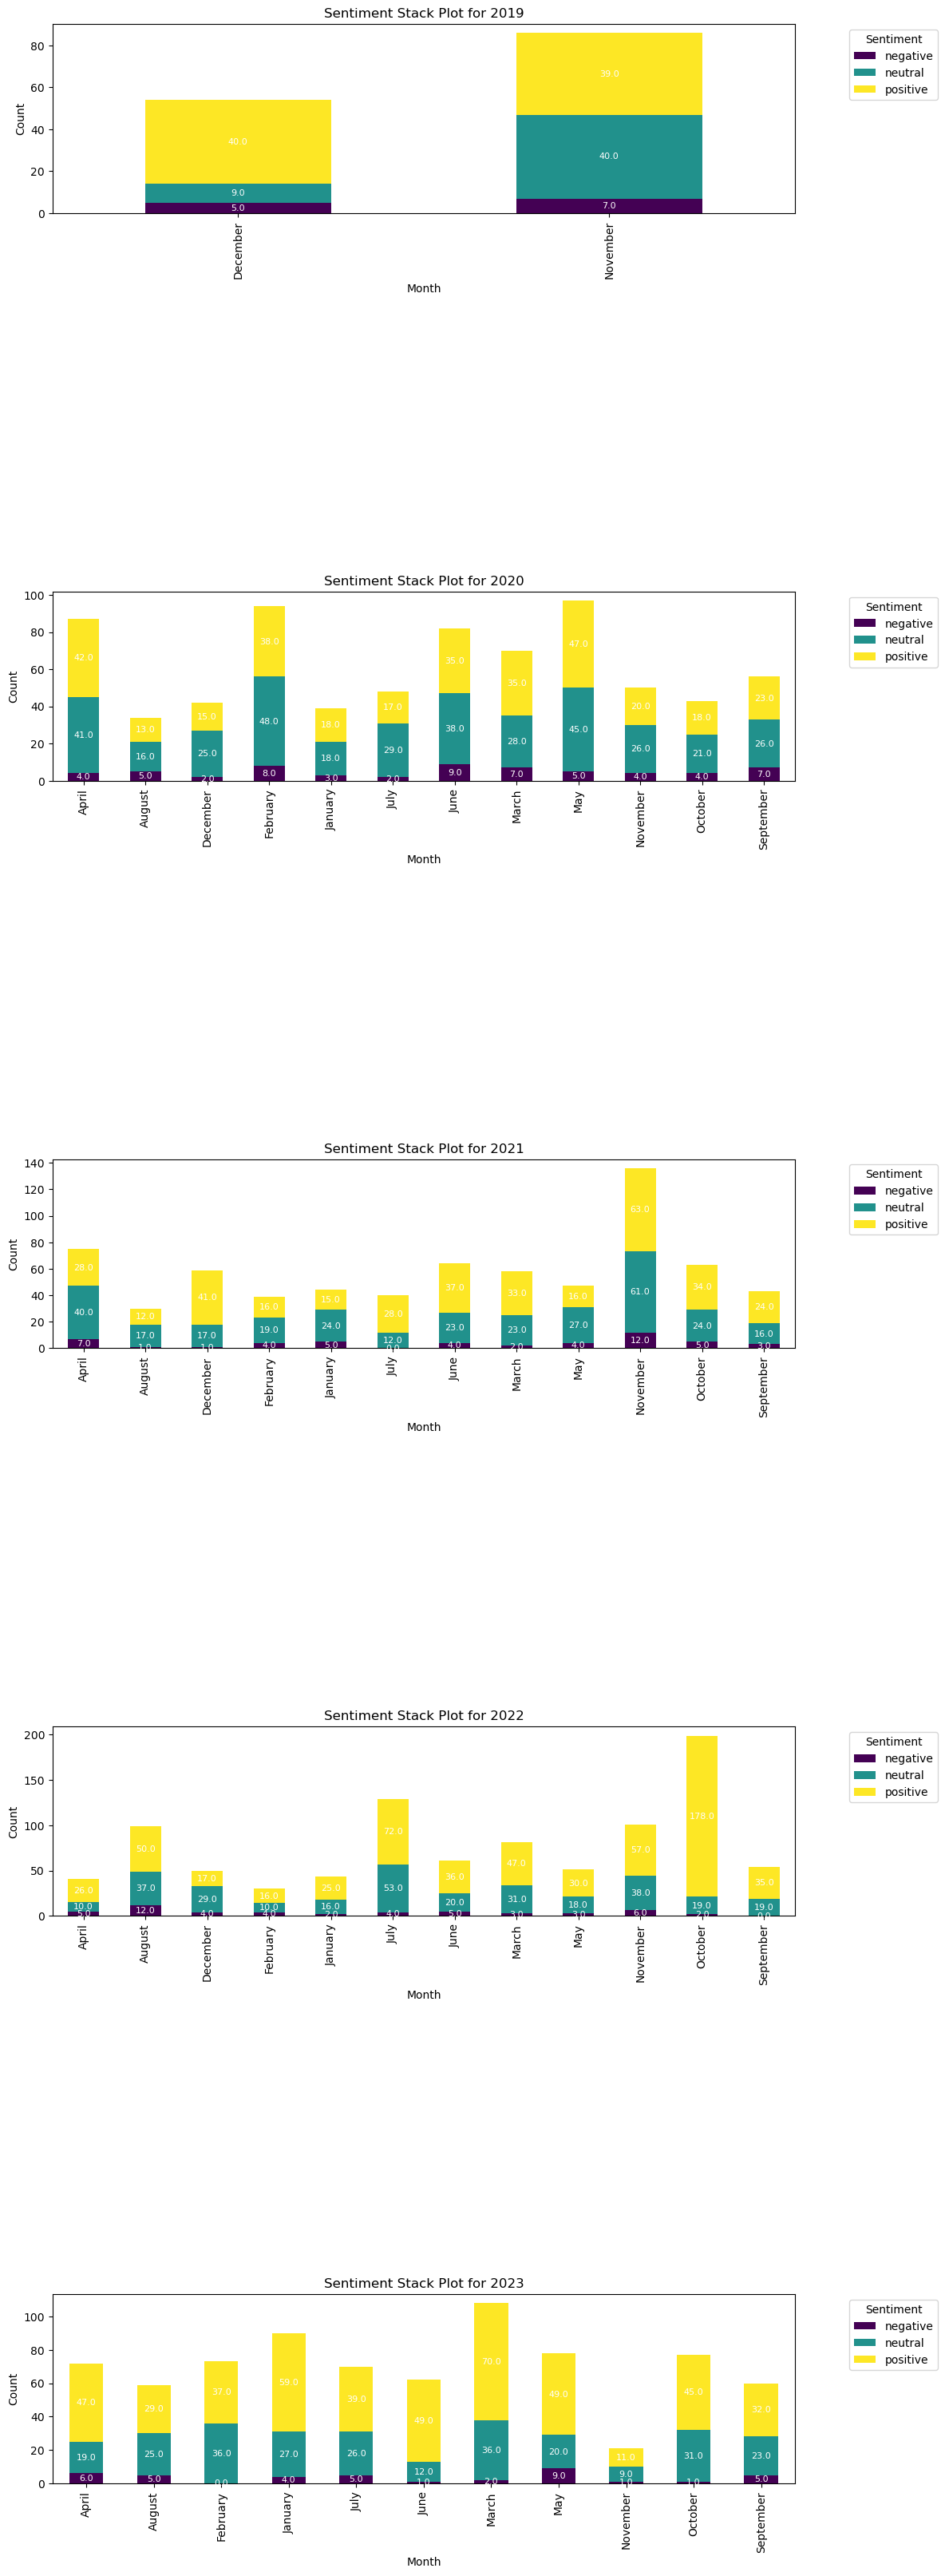

In [24]:
# Extract year and month
filtered_df['Year'] = filtered_df['UTC Date'].dt.year
filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()

# Count sentiment occurrences for each year and month
sentiment_counts = filtered_df.groupby(['Year', 'Month', 'Sentiment']).size().unstack(fill_value=0).reset_index()

# Plotting the sophisticated stacked plot
fig, axes = plt.subplots(nrows=len(sentiment_counts['Year'].unique()), ncols=1, figsize=(12, 8 * len(sentiment_counts['Year'].unique())))
plt.subplots_adjust(hspace=2)

for i, (year, data) in enumerate(sentiment_counts.groupby('Year')):
    ax = axes[i]
    data.drop('Year', axis=1).set_index('Month').plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

    # Annotating the bars with counts
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height}', (x + width/2, y + height/2), ha='center', va='center', fontsize=8, color='white')

    ax.set_title(f'Sentiment Stack Plot for {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Sentiment', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\794949978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['UTC Date'].dt.year
C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\794949978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()


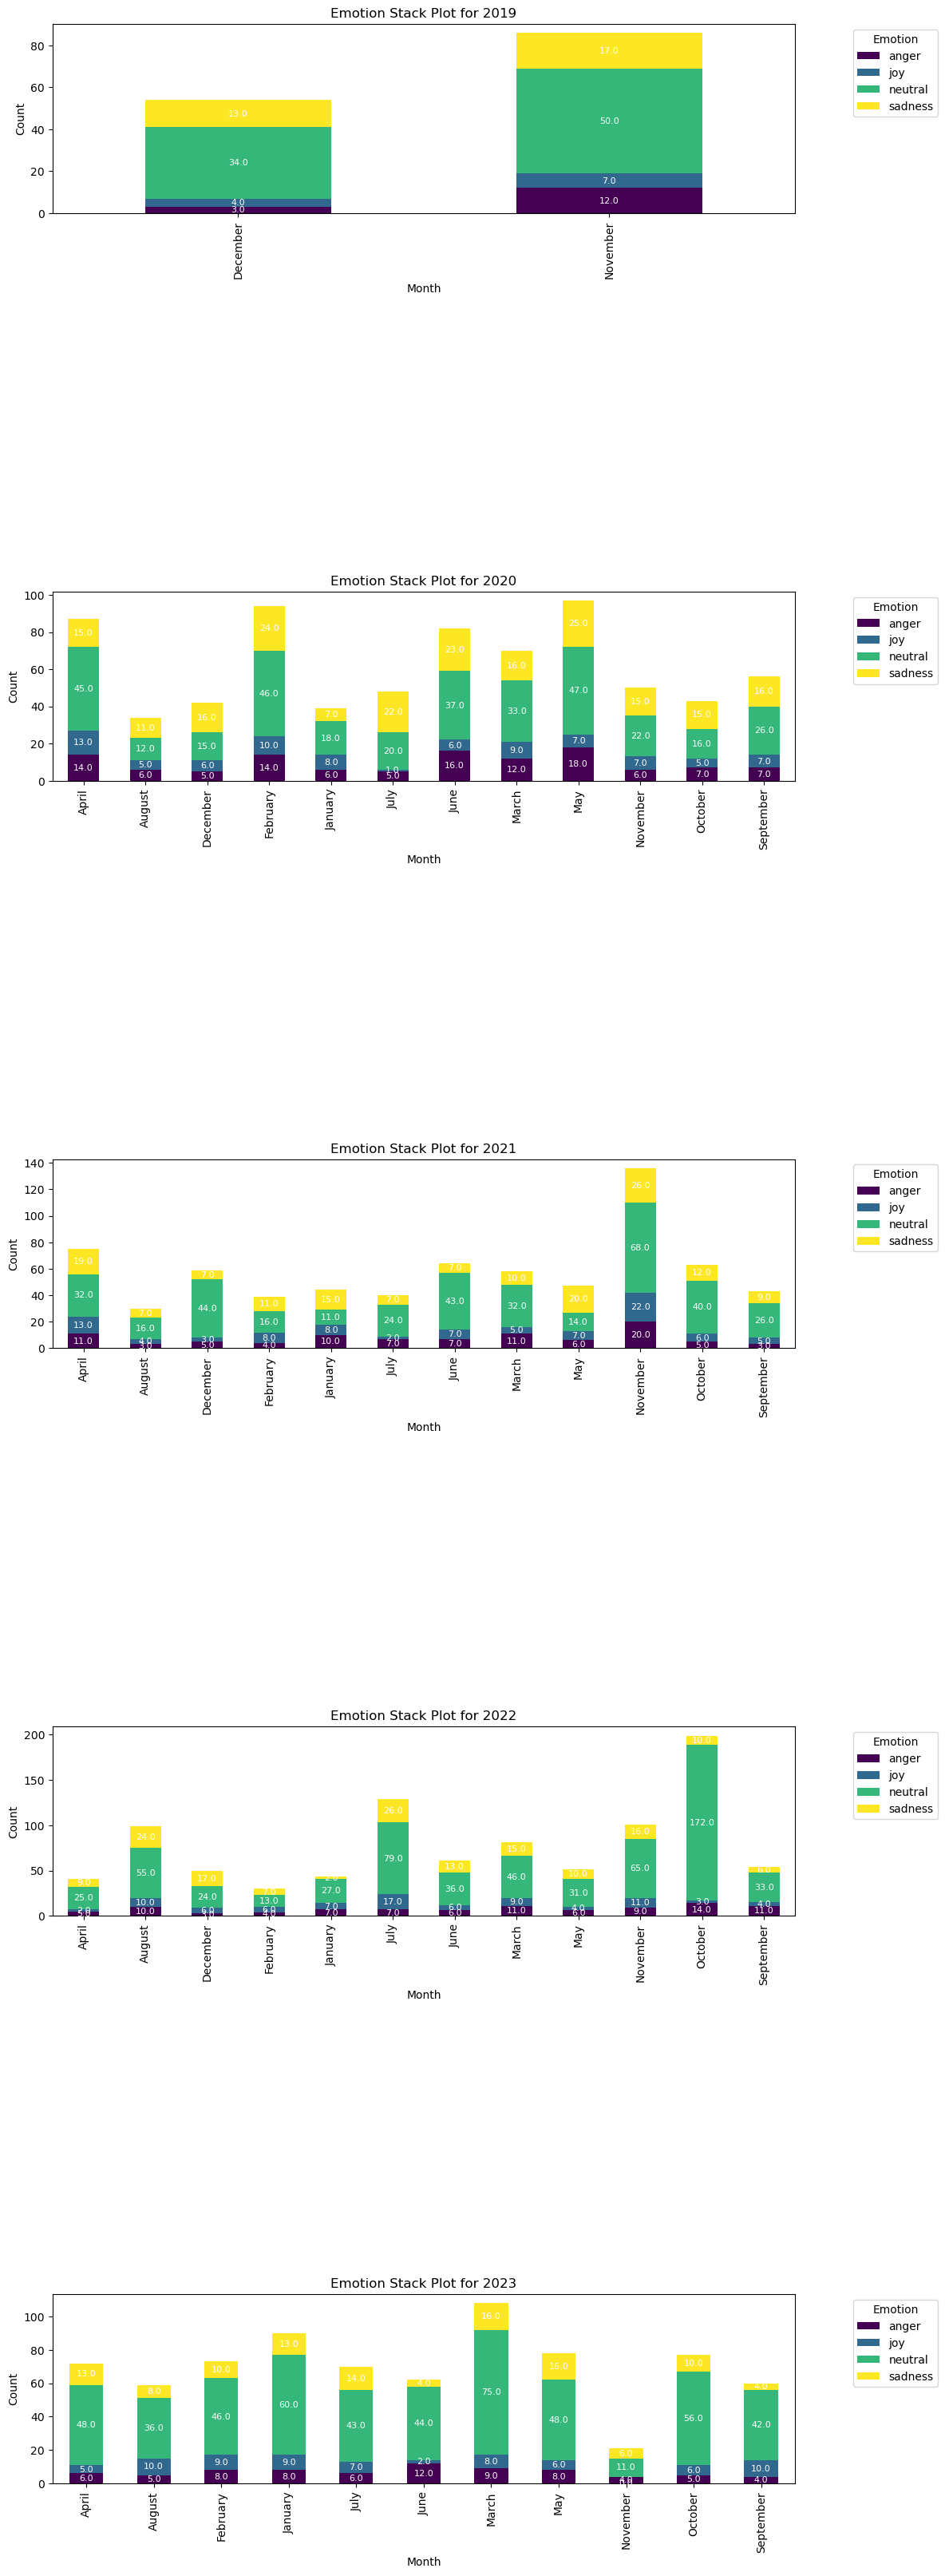

In [25]:
# Extracting year and month
filtered_df['Year'] = filtered_df['UTC Date'].dt.year
filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()

# Group by 'Year', 'Month', and 'Emotion'
emotion_counts = filtered_df.groupby(['Year', 'Month', 'Emotion']).size().unstack(fill_value=0).reset_index()

# Plotting the stacked plot
fig, axes = plt.subplots(nrows=len(emotion_counts['Year'].unique()), ncols=1, figsize=(12, 8 * len(emotion_counts['Year'].unique())))
plt.subplots_adjust(hspace=2)

for i, (year, data) in enumerate(emotion_counts.groupby('Year')):
    ax = axes[i]
    data.drop(['Year'], axis=1).set_index('Month').plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

    # Annotating the bars with counts
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height}', (x + width/2, y + height/2), ha='center', va='center', fontsize=8, color='white')

    ax.set_title(f'Emotion Stack Plot for {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Emotion', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\4091412388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['UTC Date'].dt.year
C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\4091412388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()
C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\4091412388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

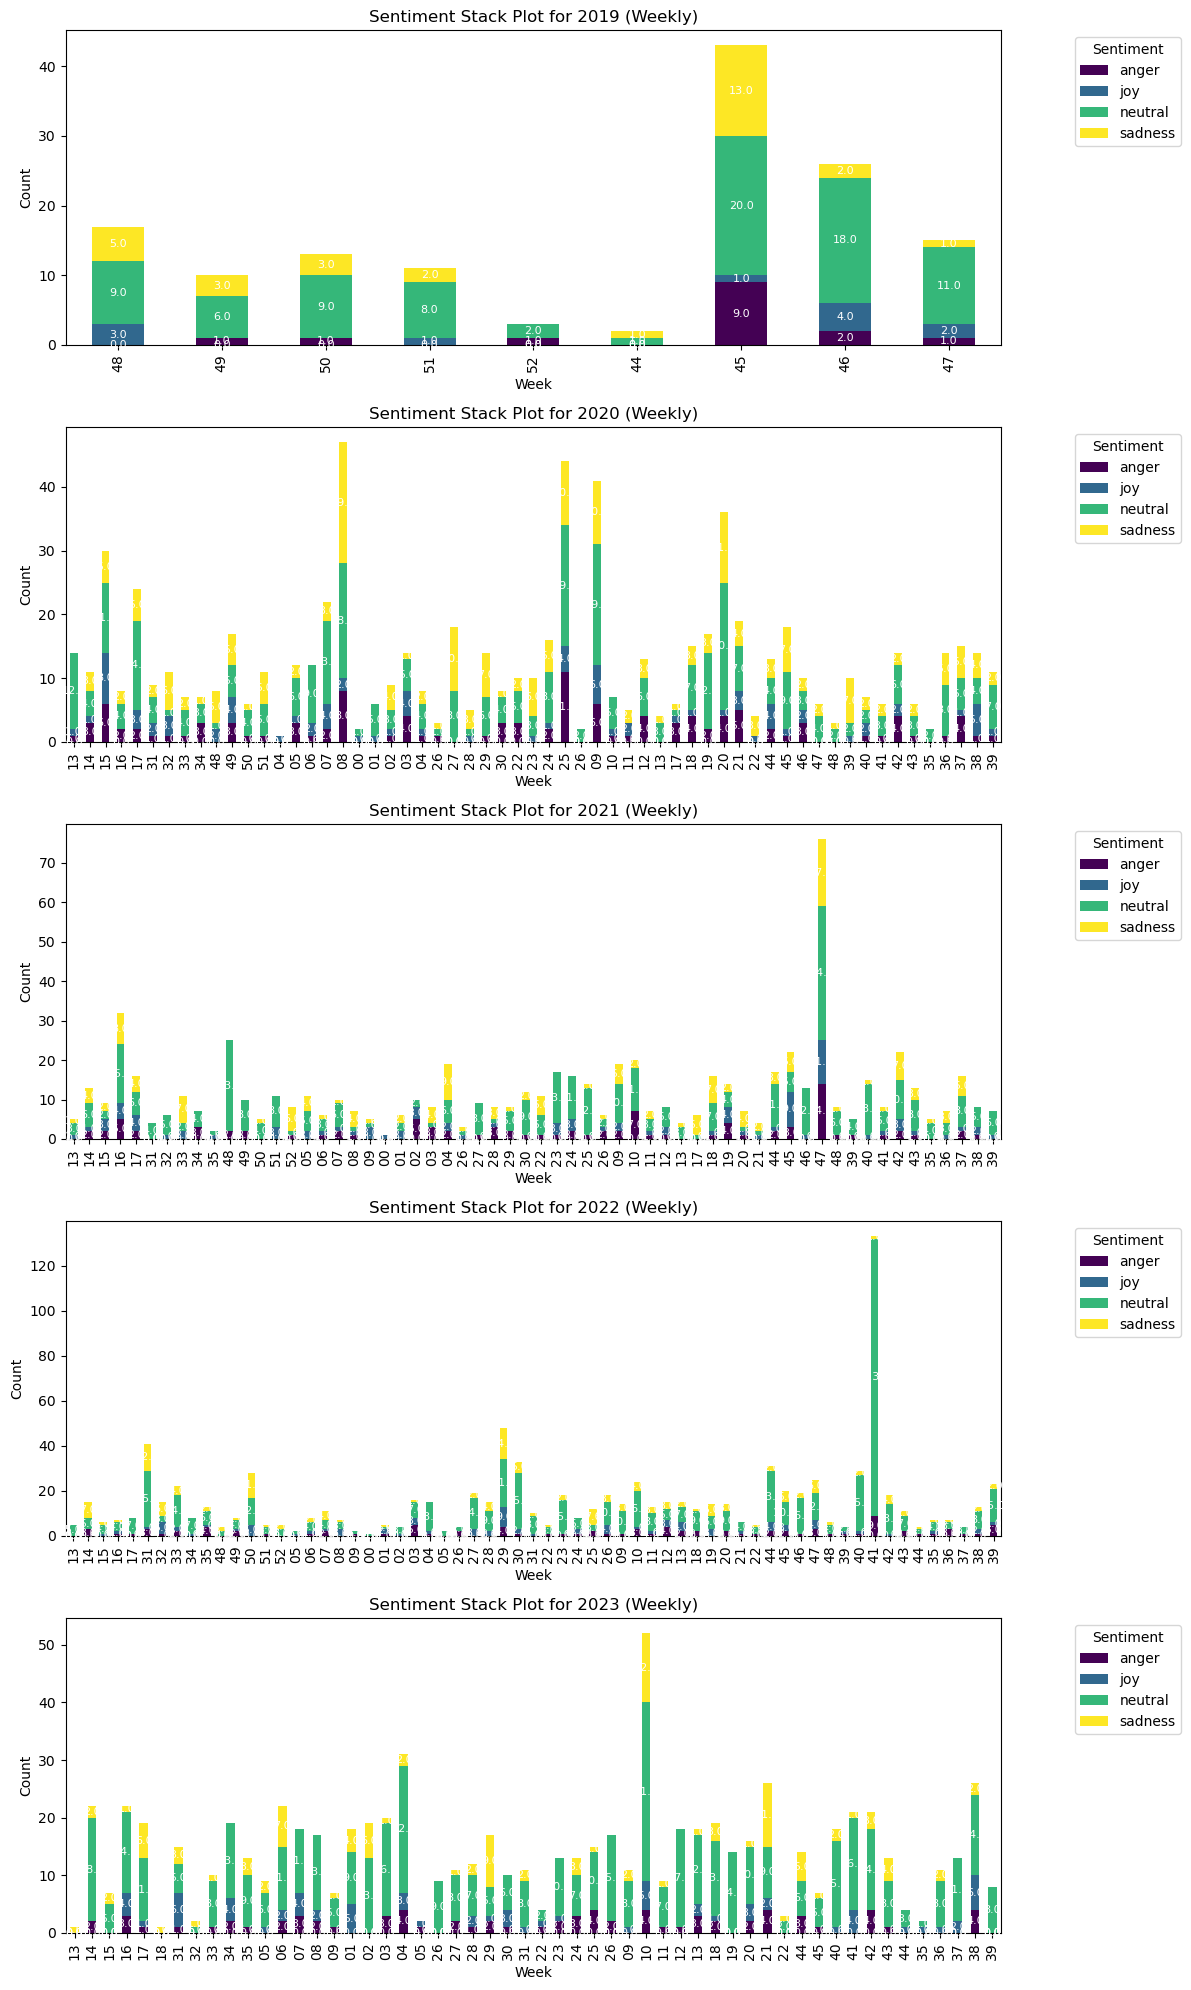

In [26]:

filtered_df['Year'] = filtered_df['UTC Date'].dt.year
filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()
filtered_df['Week'] = filtered_df['UTC Date'].dt.strftime('%U')

# Counting sentiment occurrences for each year, month, and week
sentiment_counts_weekly = filtered_df.groupby(['Year', 'Month', 'Week', 'Emotion']).size().unstack(fill_value=0).reset_index()

# Stacked bar plot 
fig, axes = plt.subplots(nrows=len(filtered_df['Year'].unique()), ncols=1, figsize=(12, 4 * len(filtered_df['Year'].unique())))
plt.subplots_adjust(hspace=0.5)

for i, (year, data) in enumerate(sentiment_counts_weekly.groupby('Year')):
    ax = axes[i]
    data.drop(['Year', 'Month'], axis=1).set_index('Week').plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

    # Annotating the bars with counts
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height}', (x + width/2, y + height/2), ha='center', va='center', fontsize=8, color='white')

    ax.set_title(f'Sentiment Stack Plot for {year} (Weekly)')
    ax.set_xlabel('Week')
    ax.set_ylabel('Count')
    ax.legend(title='Sentiment', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()

plt.show()


C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\3296772431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packa

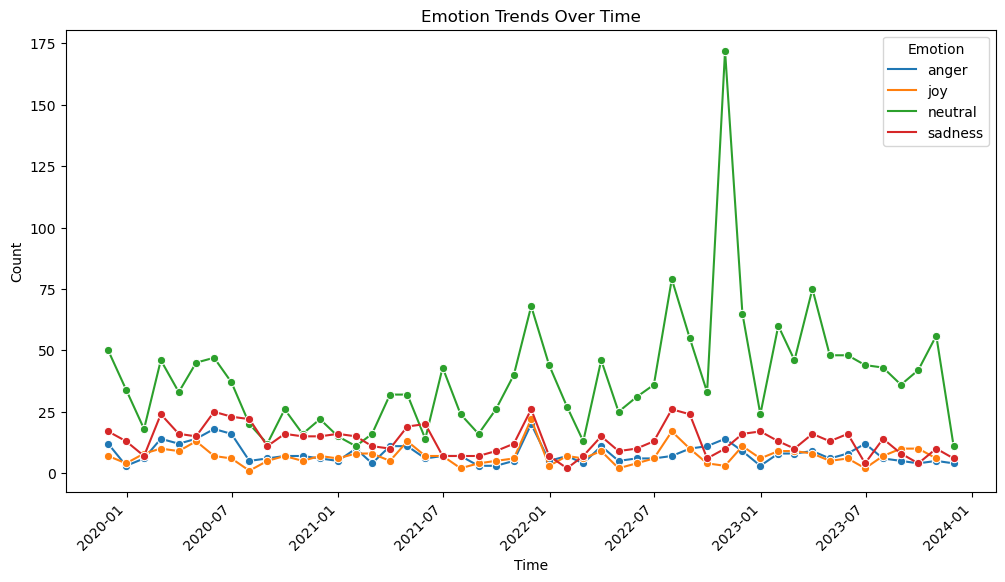

In [27]:
filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])
time_frequency = 'M'

# Grouping by 'Emotion' and the specified time frequency
grouped_data = filtered_df.groupby(['Emotion', pd.Grouper(key='UTC Date', freq=time_frequency)]).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='UTC Date', y='Count', hue='Emotion', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Emotion Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Count')

plt.show()

C:\Users\Amro\AppData\Local\Temp\ipykernel_15064\2481046405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packa

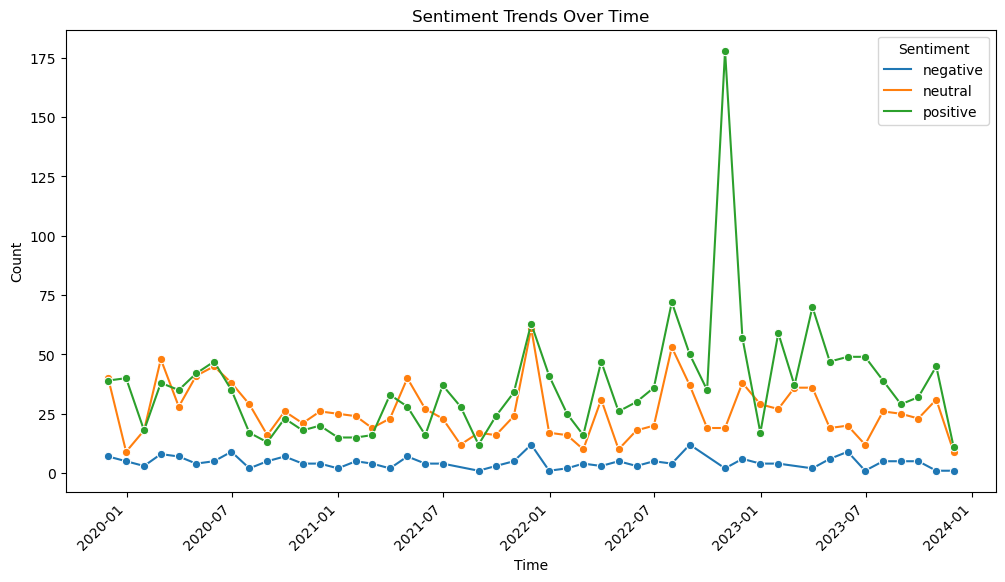

In [28]:
filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])
time_frequency = 'M'

# Grouping by 'Emotion' and the specified time frequency
grouped_data = filtered_df.groupby(['Sentiment', pd.Grouper(key='UTC Date', freq=time_frequency)]).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='UTC Date', y='Count', hue='Sentiment', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Count')

plt.show()

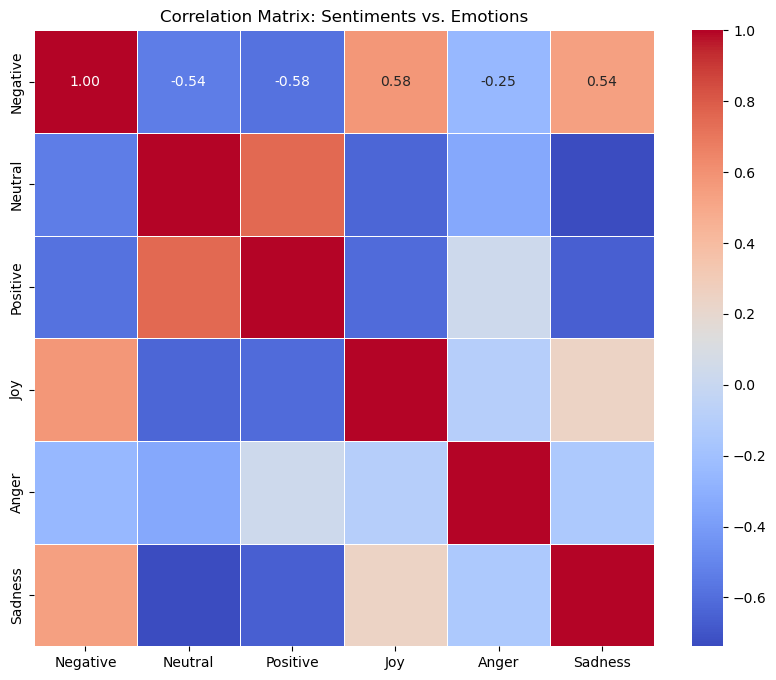

In [29]:
# Select relevant columns for correlation analysis
sentiment_columns = ['Negative', 'Neutral', 'Positive']
emotion_columns = ['Joy', 'Anger', 'Sadness']

# Create a subset DataFrame with selected columns
correlation_df = filtered_df[sentiment_columns + emotion_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix: Sentiments vs. Emotions')
plt.show()

In [39]:
emotions_to_display = ['neutral', 'anger', 'joy', 'sadness']


sampled_rows = {}

# Iterating through each emotion 
for emotion in emotions_to_display:
    sampled_rows[emotion] = filtered_df[filtered_df['Emotion'] == emotion].sample(50)


result_df = pd.concat(sampled_rows.values())


In [31]:
pd.set_option('display.max_rows', None)

In [32]:
pd.set_option('display.max_colwidth', None)

In [40]:
result_df

,User,UTC Date,Tweet,Cleaned_Tweet,Negative,Neutral,Positive,Sentiment,Year,Joy,Anger,Sadness,Emotion,Month,Week
2481,High Sheriff East Riding,2022-06-05 05:46:12,"@HP_CSU @ERLieutenancy @HullMinster @Humberbeat @HumbersideFire Thank you so much for the amazing greeting and farewell music, beautiful👍😊",thank much amazing greeting farewell music beautiful,0.003031,0.962083,0.980357,positive,2022,0.011826,0.012369,0.013722,neutral,June,23
3934,Roy Wilsher,2021-02-19 18:13:43,@CFOBlacksell @HumbersideFire @NFCC_FireChiefs Fantastic,fantastic,0.079689,0.953607,0.610726,positive,2021,0.020297,0.016255,0.009841,neutral,February,07
560,Together for Short Lives,2023-06-22 17:16:32,@HelpStAndrews @HumbersideFire Look at those smiles! It looks like so much fun was had 🚒 🤩,look smile look like much fun,0.003916,0.950856,0.962908,positive,2023,0.011491,0.023288,0.014366,neutral,June,25
178,Dawn Whittaker KFSM 🚒,2023-10-01 19:51:15,@HumbersideFire Half a century...amazing,half centuryamazing,0.031516,0.933703,0.620824,positive,2023,0.017164,0.033201,0.015932,neutral,October,40
1906,Stuart Donald QPM,2022-10-08 01:49:46,"@FireChiefChrisB @HumbersideFire @DebsKLB Chris, You have made a big difference. Congratulations on your retirement.",chris made big difference congratulation retirement,0.001853,0.844930,0.974246,positive,2022,0.027933,0.105280,0.021856,neutral,October,40
4528,Wolfy O'Hare,2020-06-25 13:04:17,@therroneill @AlanClark_ @Fionamills1 @Humber_01 @LouiseWriter @LucyLauraClark @RadioHumberside @andytrain @HullKRFM @parkstreethull @JohnEskimosoup @jojoetaylor23 @keeganbecky @MartinJStead @arnett_paul @HumbersideFire @WilkoSJ @Phil_Shillito @CFOBlacksell The cat was out of the bag the minute anyone mentioned glitter.,cat bag minute anyone mentioned glitter,0.207829,0.429235,0.068190,neutral,2020,0.311470,0.052916,0.206380,neutral,June,25
643,K9 fi,2023-06-04 07:54:24,Archie making new friends whilst assisting @Humberbeat @HumbersideFire with an incident yesterday. https://t.co/a0OtFRaHSC,archie making new friend whilst assisting incident yesterday,0.005677,0.619331,0.497719,positive,2023,0.066823,0.241951,0.071895,neutral,June,23
1810,Matt Woodcock,2022-10-14 15:23:55,"@FireChiefChrisB @HumbersideFire @DebsKLB @HP_CSU Brilliant service, Chris!! You're a legend...and a fabulous shepherd!! Happy retirement. 😍",brilliant service chris youre legendand fabulous shepherd happy retirement,0.001913,0.958210,0.981065,positive,2022,0.012420,0.020527,0.008843,neutral,October,41
5190,Humberside Police - North East Lincolnshire,2020-01-28 16:27:20,#GrimsbyWest #Willows Carried out a multi agency engagement event at Chatteris House this afternoon. Thank you to @Lincolnshirehp @NELCouncil @VictimSupport @HumbersideFire and the residents of Chatteris House for making it a successful afternoon. #PartnershipWorking https://t.co/w07VSRQB1l,carried multi agency engagement event chatteris house afternoon thank resident chatteris house making successful afternoon,0.002022,0.827620,0.891079,positive,2020,0.024279,0.127816,0.020285,neutral,January,04
4164,UK Fire Rescue Photos,2020-11-08 08:41:51,@sazzy_ox @HumbersideFire Yea looking forward to getting one,yea looking forward getting one,0.001705,0.771871,0.949290,positive,2020,0.038315,0.169490,0.020324,neutral,November,45


In [41]:
sentiment_to_display = ['neutral', 'negative', 'positive']


sampled_rows = {}

# Iterating through each sentiment
for sentiment in sentiment_to_display:
    sampled_rows[sentiment] = filtered_df[filtered_df['Sentiment'] == sentiment].sample(30)

# Concatenate the sampled rows into a new DataFrame
result_df1 = pd.concat(sampled_rows.values())


In [42]:
result_df1

,User,UTC Date,Tweet,Cleaned_Tweet,Negative,Neutral,Positive,Sentiment,Year,Joy,Anger,Sadness,Emotion,Month,Week
3315,Antonia,2021-09-29 07:18:58,@remmy_308 @triple_xb @CFO_LincsFire @FireChiefChrisB @LincsFireRescue @nottsfire @LeicsFireRescue @MidsDog @HumbersideFire @cambsfrs @Fleurholland2 Too loud https://t.co/S5DwxUtIbn,loud,0.188988,0.373627,0.251351,neutral,2021,0.520563,0.060593,0.045217,joy,September,39
1276,Steven J Maxson Esquire 🇬🇧,2023-01-09 12:16:47,I often wondered what would happen if someone needed rescuing from the Tower in the annual ascent by @MinsterChoirs to sing from the Tower roof on Ascension Day. Looks like @HumbersideFire were prepared for every eventuality! https://t.co/wUT6Ukqvz5,often wondered would happen someone needed rescuing tower annual ascent sing tower roof ascension day look like prepared every eventuality,0.084560,0.098163,0.067093,neutral,2023,0.071881,0.189088,0.640868,sadness,January,02
119,ben walmsley,2023-10-15 10:13:39,@UKfirestations @HumbersideFire @CFOPhilShillito 3 pumps at Grimsby? 2 full time 1 retained?,pump grimsby full time retained,0.053207,0.712784,0.097109,neutral,2023,0.104774,0.060353,0.122089,neutral,October,42
3720,Yorkshire Water 💧,2021-05-01 03:09:41,"@Fufu_Manchu_ @WYFRS @SYFR @HumbersideFire @NorthYorksFire @CanalRiverTrust @NT_TheNorth @peakdistrict @northyorkscc @Calderdale @KirkleesCouncil Hi Rayray, we cant speak for other authorities, but we warn of the danger of swimming in reservoirs due to the health &amp; safety risks posed by the sites and the hidden danger contained in many of them. If this stance changes in future then we'll be sure to promote this too.^Seyab",hi rayray cant speak authority warn danger swimming reservoir due health amp safety risk posed site hidden danger contained many stance change future well sure promote tooseyab,0.455906,0.017604,0.020177,neutral,2021,0.128756,0.149555,0.704086,sadness,May,17
2328,Holme Valley,2022-07-19 10:27:50,⚠️Water safety⚠️\n\nAn important video from Humber fire and rescue 🛟 \n\n#BeWaterAware @HumbersideFire \n\nhttps://t.co/jO7ulZkUUT,water safety important video humber fire rescue,0.076074,0.036841,0.137951,neutral,2022,0.176456,0.091350,0.695353,sadness,July,29
1252,AROUND-ANGLIA,2023-01-13 19:45:31,The latest AROUND-IMMINGHAM ! https://t.co/3pXu3M5e7X Thanks to @ThisCoast @Rank_Success @HumbersideFire #hull #grimsbyjobs,latest aroundimmingham thanks,0.011675,0.660027,0.419619,neutral,2023,0.115385,0.163338,0.061251,neutral,January,02
2354,Fortistherapy,2022-07-14 08:30:17,"We’ve told you we’re attending The Emergency Services Show, which is the UK’s leading annual showcase of the blue light sector. But do you know why?\n\nWe could fill tweet after tweet, but why not click below and read it from the experts. \n@HumbersideFire \n\nhttps://t.co/dSFONFqOqf https://t.co/zH5EVzdwK7",weve told attending emergency service show uk leading annual showcase blue light sector know could fill tweet tweet click read expert,0.029286,0.243753,0.131760,neutral,2022,0.199075,0.254903,0.302269,sadness,July,28
3088,Roy (Zeeta),2021-11-24 14:22:36,@HumbersideFire @Hullccnews I thought you'd brought me a purple heart 💜😀,thought youd brought purple heart,0.036181,0.809447,0.245067,neutral,2021,0.065414,0.066259,0.058880,neutral,November,47
1149,Pickering Fire Station,2023-02-06 10:56:09,"Last night, ourselves, @ScarboroughFir2,@NYFRS_RHB, Filey &amp; Bridlingtons ALP (@HumbersideFire) attended a fire in a commercial premises in East Ayton. Hose reels, main jets, lighting &amp; small tools were used to extinguish the fire. Fire investigation &amp; revisit to take place today.",last night filey amp bridlingtons alp attended fire commercial premise east ayton hose reel main jet lighting amp small tool used extinguish fire fire investigation amp revisit take place today,0.126661,0.127293,0.026773,neutral,2023,0.272081,0.100783,0.499843,sadness,February,06
1459,Gender Pay Gap Bot,2022-11-21 11:10:45,"In this organisation, women'